## Imports

In [1]:
seed = 17
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns
import pickle

# Main

### LOAD DATA

In [2]:
# LOAD DATA
# Lists of observations and targets
Xs = []
ys = []

Xs.append(pd.read_csv("../data/credit_X.csv"))
Xs.append(pd.read_csv("../data/raisin_X.csv"))
Xs.append(pd.read_csv("../data/alzheimer_X.csv"))
Xs.append(pd.read_csv("../data/salary_X.csv"))

ys.append(pd.read_csv("../data/credit_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/raisin_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/alzheimer_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/salary_y.csv").iloc[:, 0])

## Functions

In [5]:
def tune_with_random_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        # in my case works faster with n_jobs=-1
        opt = RandomizedSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed, n_jobs=-1)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results
    
def tune_with_bayes_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        opt = BayesSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results

def get_tunability(model_class, default_grid, tuned_grids, scoring):
    tunabilities = []
    for i in range(4):
        # Replace key "model__hiperparameter" to key "hiperparameter"
        cleaned_params = {key.replace('model__', ''): value for key, value in tuned_grids[i].best_params_.items()}
        pipe_default = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**default_grid))
        ])
        pipe_tuned = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**cleaned_params))            
        ])
        
        default_score = cross_val_score(pipe_default, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tuned_score = cross_val_score(pipe_tuned, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tunabilities.append(tuned_score - default_score)
    return tunabilities

def save_result(result, path_to_save):
    with open(path_to_save, 'wb') as file:
        pickle.dump(result, file)

def load_result(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

def get_deafult_score(model_class, default_grid, scoring):
    default_scores = []
    for i in range(4):
        pipe_default = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**default_grid))
        ])
        default_score = cross_val_score(pipe_default, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        default_scores.append(default_score)
    return default_scores

## Logistic Regression
For now just to see how long it will work etc..

### Algorithm tunability

#### RandomSearch

In [4]:
# More possibilities of these parameters are possible but idk how to manage an exception when one parameter works only when another is set to some value
# For example when penalty equals elasticnet there must be specified l1_ratio which isn't possible to define if other options of penalty are set
# Then a solution is needed but for now I won't think about it
search_grid = {
    'model__C': stats.loguniform(1e-4, 1e4),
    'model__penalty': ['l1', 'l2'],            
    'model__solver': ['liblinear', 'saga'],
    "model__class_weight": [None, "balanced"],
    "model__max_iter": [10000],
    "model__random_state": [seed]
}
pipe = Pipeline(steps=[
    ("preprocessing", MinMaxScaler()),
    ("model", LogisticRegression())
])

In [5]:
%%time
# Tuning using randomsearch
lr_opt_results_rs = tune_with_random_search(pipe, search_grid, 100, "roc_auc")

CPU times: total: 5.67 s
Wall time: 4min 7s


In [6]:
# Save tuning
save_result(lr_opt_results_rs, "./saved_results/lr_opt_results_rs.pkl")

In [7]:
# Best params:
for i in range(4):
    print(lr_opt_results_rs[i].best_params_)

{'model__C': 0.050224698836588255, 'model__class_weight': None, 'model__max_iter': 10000, 'model__penalty': 'l1', 'model__random_state': 17, 'model__solver': 'liblinear'}
{'model__C': 17.81017448380737, 'model__class_weight': None, 'model__max_iter': 10000, 'model__penalty': 'l1', 'model__random_state': 17, 'model__solver': 'saga'}
{'model__C': 0.15914466424851323, 'model__class_weight': None, 'model__max_iter': 10000, 'model__penalty': 'l1', 'model__random_state': 17, 'model__solver': 'saga'}
{'model__C': 2.8713685700410183, 'model__class_weight': None, 'model__max_iter': 10000, 'model__penalty': 'l1', 'model__random_state': 17, 'model__solver': 'saga'}


In [8]:
# Tunabilities scores on diffrent datasets
lr_tunabilities_rs = get_tunability(LogisticRegression, {"random_state": seed, "max_iter": 10000}, lr_opt_results_rs, "roc_auc")
lr_tunabilities_rs

[0.032628834067978785,
 0.009283950617284042,
 0.003899183522268146,
 0.009277662850375012]

#### BayesSearch

In [9]:
search_grid = {
    'model__C': Real(1e-4, 1e4, prior='log-uniform'),
    'model__penalty': Categorical(['l1', 'l2']),            
    'model__solver': Categorical(['liblinear', 'saga']),
    "model__class_weight": Categorical([None, "balanced"]),
    "model__max_iter": Categorical([10000]),
    "model__random_state": Categorical([seed])
}
pipe = Pipeline(steps=[
    ("preprocessing", MinMaxScaler()),
    ("model", LogisticRegression())
])

In [10]:
# Much more time than in randomized version

In [11]:
%%time
# Tuning using bayessearch
lr_opt_results_bs = tune_with_bayes_search(pipe, search_grid, 100, "roc_auc")

C:\Users\barto\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10000.0, None, 10000, 'l2', 17, 'liblinear'] before, using random point [0.29034138343288396, None, 10000, 'l2', 17, 'saga']
  warnings.warn(
C:\Users\barto\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10000.0, None, 10000, 'l2', 17, 'liblinear'] before, using random point [0.01642959027550515, None, 10000, 'l1', 17, 'liblinear']
  warnings.warn(
C:\Users\barto\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10000.0, 'balanced', 10000, 'l2', 17, 'liblinear'] before, using random point [0.006268463396658816, 'balanced', 10000, 'l1', 17, 'liblinear']
  warnings.warn(


CPU times: total: 42min 47s
Wall time: 39min 58s


In [12]:
# Save results
save_result(lr_opt_results_bs, "./saved_results/lr_opt_results_bs.pkl")

In [13]:
# Best params:
for i in range(4):
    print(lr_opt_results_bs[i].best_params_)

OrderedDict({'model__C': 0.1875676714781556, 'model__class_weight': None, 'model__max_iter': 10000, 'model__penalty': 'l1', 'model__random_state': 17, 'model__solver': 'saga'})
OrderedDict({'model__C': 17.037927861455938, 'model__class_weight': 'balanced', 'model__max_iter': 10000, 'model__penalty': 'l1', 'model__random_state': 17, 'model__solver': 'saga'})
OrderedDict({'model__C': 0.2354658367757333, 'model__class_weight': None, 'model__max_iter': 10000, 'model__penalty': 'l1', 'model__random_state': 17, 'model__solver': 'saga'})
OrderedDict({'model__C': 5.166817922473665, 'model__class_weight': None, 'model__max_iter': 10000, 'model__penalty': 'l1', 'model__random_state': 17, 'model__solver': 'saga'})


In [14]:
# Tunabilities scores on diffrent datasets
lr_tunabilities_bs = get_tunability(LogisticRegression, {"random_state": seed, "max_iter": 10000}, lr_opt_results_bs, "roc_auc")
lr_tunabilities_bs

[0.027346095972740736,
 0.009456790123456793,
 0.003752954315248247,
 0.009228151072509405]

#### Plots

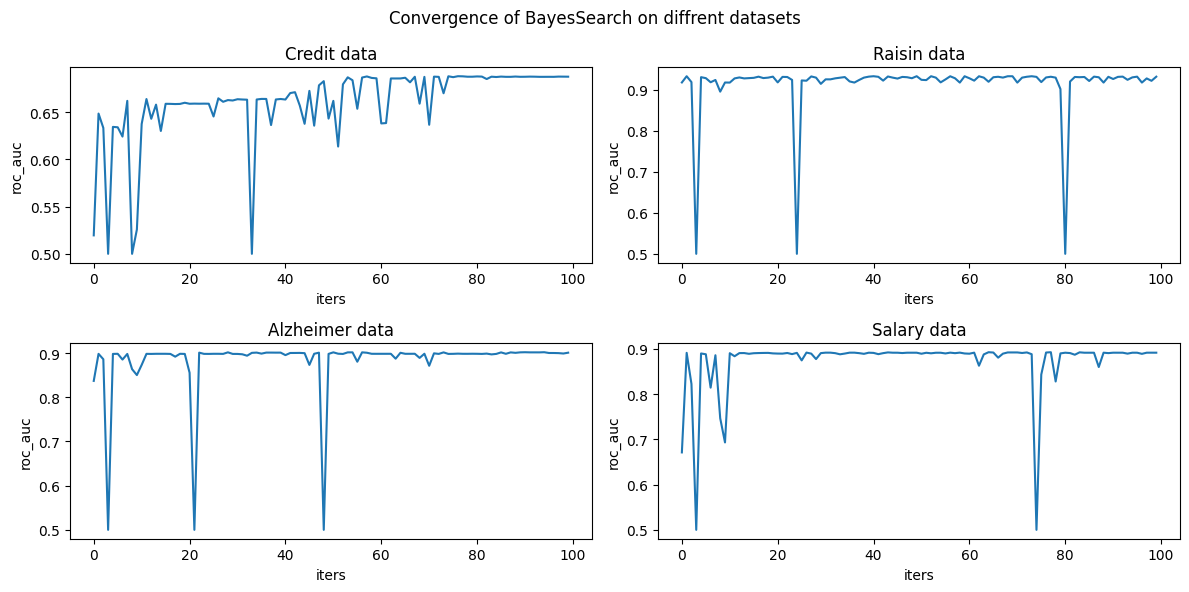

In [15]:
titles = ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]
fig, axs = plt.subplots(2, 2, figsize = (12, 6))
axs = axs.flatten()
fig.suptitle("Convergence of BayesSearch on diffrent datasets")
for i in range(4):
    axs[i].plot(lr_opt_results_bs[i].cv_results_["mean_test_score"])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("iters")
    axs[i].set_ylabel("roc_auc")
plt.tight_layout()
plt.show()

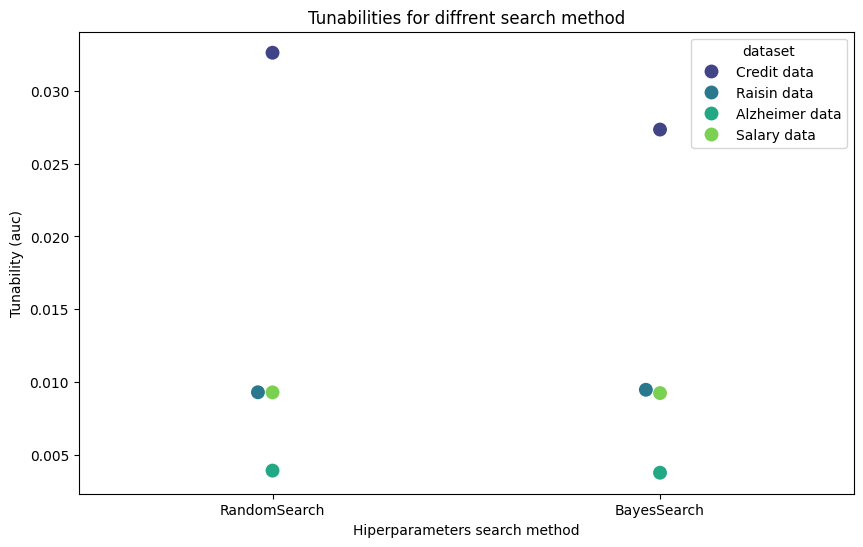

In [16]:
data = {
    'tunability': lr_tunabilities_rs + lr_tunabilities_bs,
    'alg': ["RandomSearch"] *  4 + ["BayesSearch"] * 4,
    'dataset': ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]*2
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.swarmplot(x='alg', y='tunability', hue='dataset', data=df, palette='viridis', size=10)

plt.title('Tunabilities for diffrent search method')
plt.xlabel('Hiperparameters search method')
plt.ylabel('Tunability (auc)')
plt.show()

In [17]:
# Bcs lr has only one important parameter to tune ("C") by analizing whole algorithm tunability there is also analized tunability of "C" 
#hence i wont do hyperparameter tuning again.

### Histogram of metric value differences

In [7]:
lr_opt_results_rs = load_result("./saved_results/lr_opt_results_rs.pkl")
lr_opt_results_bs = load_result("./saved_results/lr_opt_results_bs.pkl")

In [8]:
default_score = get_deafult_score(LogisticRegression, {'random_state': seed}, 'roc_auc')
default_score

[0.6606023727734254,
 0.9229382716049382,
 0.8980856413102465,
 0.8833195104619029]

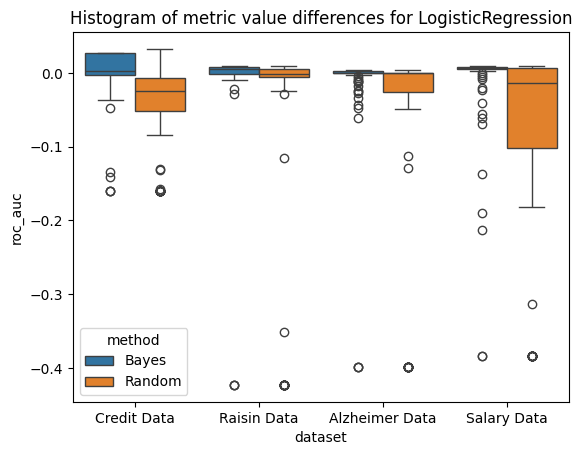

In [9]:
data = {
    'Credit Data': lr_opt_results_bs[0].cv_results_["mean_test_score"]-default_score[0],
    'Raisin Data': lr_opt_results_bs[1].cv_results_["mean_test_score"]-default_score[1],
    'Alzheimer Data': lr_opt_results_bs[2].cv_results_["mean_test_score"]-default_score[2],
    'Salary Data': lr_opt_results_bs[3].cv_results_["mean_test_score"]-default_score[3]
}
data_random = {
    'Credit Data': lr_opt_results_rs[0].cv_results_["mean_test_score"]-default_score[0],
    'Raisin Data': lr_opt_results_rs[1].cv_results_["mean_test_score"]-default_score[1],
    'Alzheimer Data': lr_opt_results_rs[2].cv_results_["mean_test_score"]-default_score[2],
    'Salary Data': lr_opt_results_rs[3].cv_results_["mean_test_score"]-default_score[3]
} 
data = pd.DataFrame(data)
data_random = pd.DataFrame(data_random)
# connect datasets data and data_random, adding column with method Random and Bayes 
data['method'] = 'Bayes'
data_random['method'] = 'Random'
data = pd.concat([data, data_random])
data = data.melt(id_vars='method', var_name='dataset', value_name='roc_auc')

sns.boxplot(x='dataset', y='roc_auc', hue='method', data=data)
plt.title('Histogram of metric value differences for LogisticRegression')
plt.show()